In [1]:
# Auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
import pymupdf  # imports the pymupdf library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

doc = pymupdf.open("pdfs/sample2.pdf")  # open a document.

In [3]:
def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

Page size: 1191.050048828125 x 842.3900146484375
Table 0 detected with bbox: (884.5130004882812, 797.0357055664062, 1190.550048828125, 842.3900146484375)
Table 0 column names: ['', '', '6 Urh'], external: True


,Col0,Col1,6 Urh
0,,=F,&EFA1
1,None,Not-Halt-System\n+UC1\nSchaltschrank 1,SPS-Kartenübersicht\nSeite 5\nSeite 24 von 148


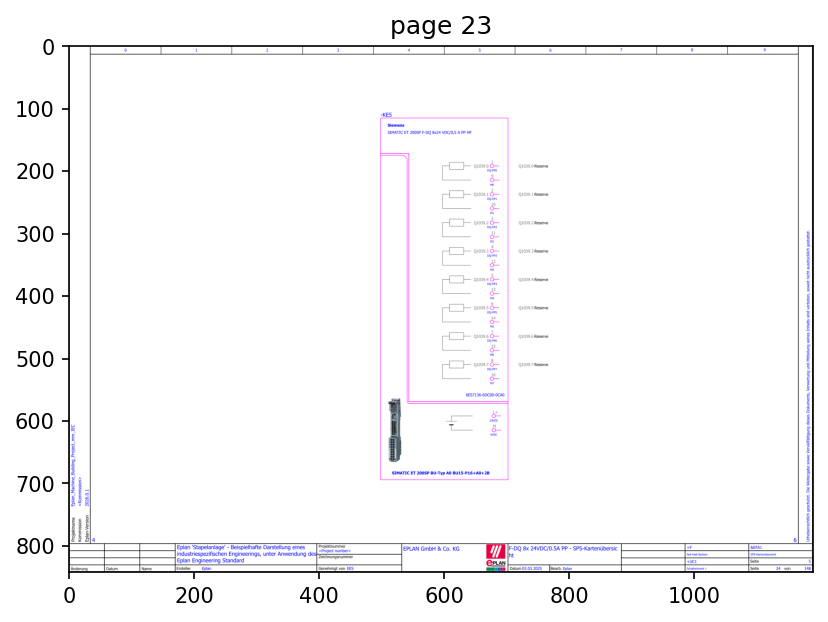

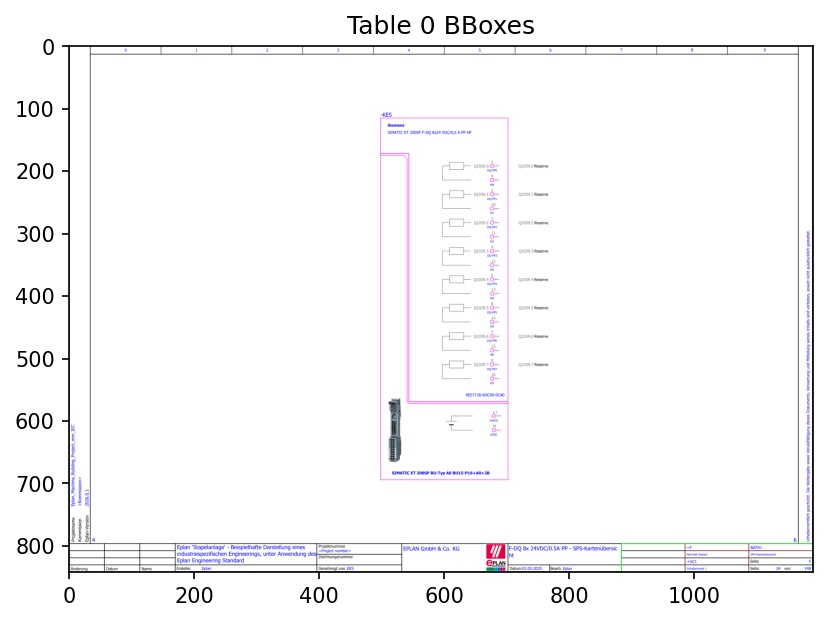

In [4]:
# The goal is to extract the footer, It's a table at the bottom of the page.
doc = pymupdf.open("pdfs/sample2.pdf")  # open a document.

page = doc.load_page(23)  # a random page to taste, page 23
show_image(page, "page 23")
page_h = page.rect.height
page_w = page.rect.width
print(f"Page size: {page_w} x {page_h}")
tables = page.find_tables(
    clip=pymupdf.Rect(882, page_h - 55, page_w, page_h)
)  # detect the tables in the footer area

for i, table in enumerate(tables):
    # make a deep copy
    print(f"Table {i} detected with bbox: {table.bbox}")
    for cell in table.cells:
        page.draw_rect(cell, width=0.3, color=pymupdf.pdfcolor["red"])
    page.draw_rect(table.bbox, color=pymupdf.pdfcolor["green"])
    print(
        f"Table {i} column names: {table.header.names}, external: {table.header.external}"
    )
    show_image(page, f"Table {i} BBoxes")
    df = table.to_pandas()  # convert to a pandas DataFrame
    display(df)

In [5]:
# define a type to represent the paper type
from footers import extract_footer

foot = extract_footer(doc.load_page(45), verbose=True)
print(foot)
# Test the refactored function
# doc = pymupdf.open("pdfs/sample4.pdf")  # open a document

PageFooter(project_name="Eplan 'Stapelanlage' - Beispielhafte Darstellung eines\nindustriespezifischen Engineerings, unter Anwendung des\nEplan Engineering Standard", product_name='ET 200eco - Versorgung DC 24 V', tags=[Tag(tag_str='=K2', tag_parts={'=': 'K2'}), Tag(tag_str='+BB1', tag_parts={'+': 'BB1'}), Tag(tag_str='&EFS1', tag_parts={'&': 'EFS1'})])


In [8]:
pages_footers = []

for i in range(len(doc)):
    page = doc.load_page(i)
    footer = extract_footer(page, verbose=False)
    pages_footers.append(footer)
print(f"Extracted footers from {len(pages_footers)} pages")

projectName not found in page: 149, The page most probably has no footer, returning None to be safe


Extracted footers from 149 pages


We have a triple ids for each page, incorporating the levels I guess, Lets try to visualize them in a tree structure with common parent nodes.

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx


def build_hierarchy_tree(pages_footers):
    """
    Build a hierarchical tree structure from the footer data.

    Args:
        pages_footers: List of footer dictionaries extracted from pages

    Returns:
        dict: Nested dictionary representing the tree structure
        list: List of all hierarchy tuples for reference
    """
    hierarchy_data = []
    tree = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # Extract hierarchy from all pages
    for i, footer in enumerate(pages_footers):
        if footer is not None:
            hierarchy = get_hirarchy_from_footer(footer)
            if hierarchy[0] is not None:  # Check if we have valid hierarchy data
                level1, level2, level3 = hierarchy
                hierarchy_data.append((level1, level2, level3, i))

                # Build nested tree structure
                tree[level1][level2][level3].append(i)

    return dict(tree), hierarchy_data


def visualize_hierarchy_tree(tree_data, max_nodes=500):
    """
    Visualize the hierarchy tree using networkx and matplotlib.

    Args:
        tree_data: Nested dictionary representing the tree structure
        max_nodes: Maximum number of nodes to display (to avoid overcrowding)
    """
    G = nx.DiGraph()
    pos = {}
    node_colors = []
    node_sizes = []
    labels = {}

    # Add root node
    root = "Root"
    G.add_node(root)
    labels[root] = "Document"
    node_colors.append("lightblue")
    node_sizes.append(1000)
    pos[root] = (0, 3)

    level1_x = 0
    for level1, level2_dict in tree_data.items():
        if len(G.nodes()) > max_nodes:
            break

        # Add level 1 nodes
        level1_node = f"L1_{level1}"
        G.add_node(level1_node)
        G.add_edge(root, level1_node)
        labels[level1_node] = level1[:15] + "..." if len(level1) > 15 else level1
        node_colors.append("lightgreen")
        node_sizes.append(800)
        pos[level1_node] = (level1_x, 2)

        level2_x = level1_x - len(level2_dict) * 0.5 + 0.5
        for level2, level3_dict in level2_dict.items():
            if len(G.nodes()) > max_nodes:
                break

            # Add level 2 nodes
            level2_node = f"L2_{level1}_{level2}"
            G.add_node(level2_node)
            G.add_edge(level1_node, level2_node)
            labels[level2_node] = level2[:10] + "..." if len(level2) > 10 else level2
            node_colors.append("lightyellow")
            node_sizes.append(600)
            pos[level2_node] = (level2_x, 1)

            level3_x = level2_x - len(level3_dict) * 0.3 + 0.15
            for level3, pages in level3_dict.items():
                if len(G.nodes()) > max_nodes:
                    break

                # Add level 3 nodes
                level3_node = f"L3_{level1}_{level2}_{level3}"
                G.add_node(level3_node)
                G.add_edge(level2_node, level3_node)
                labels[level3_node] = (
                    f"{level3[:8]}... ({len(pages)} pages)"
                    if len(level3) > 8
                    else f"{level3} ({len(pages)} pages)"
                )
                node_colors.append("lightcoral")
                node_sizes.append(400)
                pos[level3_node] = (level3_x, 0)

                level3_x += 0.3
            level2_x += 1
        level1_x += len(level2_dict) + 1

    # Create the visualization
    plt.figure(figsize=(20, 12))
    nx.draw(
        G,
        pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        font_size=8,
        font_weight="bold",
        with_labels=True,
        arrows=True,
        edge_color="gray",
        arrowsize=20,
        arrowstyle="->",
    )

    plt.title("Document Hierarchy Tree Structure", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

    return G


def print_hierarchy_summary(tree_data, hierarchy_data):
    """Print a summary of the hierarchy structure."""
    print("=== HIERARCHY SUMMARY ===")
    print(f"Total valid pages with hierarchy: {len(hierarchy_data)}")
    print(f"Number of Level 1 categories: {len(tree_data)}")

    total_level2 = sum(len(level2_dict) for level2_dict in tree_data.values())
    total_level3 = sum(
        len(level3_dict)
        for level2_dict in tree_data.values()
        for level3_dict in level2_dict.values()
    )

    print(f"Number of Level 2 categories: {total_level2}")
    print(f"Number of Level 3 categories: {total_level3}")
    print()

    # Print top-level structure
    for level1, level2_dict in list(tree_data.items())[:5]:  # Show first 5
        print(f"📁 {level1}")
        for level2, level3_dict in list(level2_dict.items())[
            :3
        ]:  # Show first 3 per level1
            print(f"  📂 {level2}")
            for level3, pages in list(level3_dict.items())[
                :3
            ]:  # Show first 3 per level2
                print(f"    📄 {level3} ({len(pages)} pages)")
            if len(level3_dict) > 3:
                print(f"    ... and {len(level3_dict) - 3} more")
        if len(level2_dict) > 3:
            print(f"  ... and {len(level2_dict) - 3} more")
        print()

    if len(tree_data) > 5:
        print(f"... and {len(tree_data) - 5} more top-level categories")


# Build and visualize the hierarchy
tree_data, hierarchy_data = build_hierarchy_tree(pages_footers)
print_hierarchy_summary(tree_data, hierarchy_data)
visualize_hierarchy_tree(tree_data)

NameError: name 'get_hirarchy_from_footer' is not defined

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx
from collections import defaultdict


def create_interactive_hierarchy_tree(tree_data, max_nodes=100):
    """
    Create an interactive hierarchical tree visualization using Plotly.

    Args:
        tree_data: Nested dictionary representing the tree structure
        max_nodes: Maximum number of nodes to display
    """
    G = nx.DiGraph()
    node_info = {}  # Store additional info for each node

    # Add root node
    root = "Root"
    G.add_node(root)
    node_info[root] = {
        "level": 0,
        "pages": [],
        "full_name": "Document Root",
        "type": "root",
    }

    # Build the graph
    node_count = 1
    level1_x = 0

    for level1, level2_dict in tree_data.items():
        if node_count > max_nodes:
            break

        # Add level 1 nodes
        level1_node = f"L1_{level1}"
        G.add_node(level1_node)
        G.add_edge(root, level1_node)

        level1_pages = []
        for l2_dict in level2_dict.values():
            for l3_pages in l2_dict.values():
                level1_pages.extend(l3_pages)

        node_info[level1_node] = {
            "level": 1,
            "pages": level1_pages,
            "full_name": level1,
            "type": "level1",
        }
        node_count += 1

        for level2, level3_dict in level2_dict.items():
            if node_count > max_nodes:
                break

            # Add level 2 nodes
            level2_node = f"L2_{level1}_{level2}"
            G.add_node(level2_node)
            G.add_edge(level1_node, level2_node)

            level2_pages = []
            for l3_pages in level3_dict.values():
                level2_pages.extend(l3_pages)

            node_info[level2_node] = {
                "level": 2,
                "pages": level2_pages,
                "full_name": level2,
                "type": "level2",
            }
            node_count += 1

            for level3, pages in level3_dict.items():
                if node_count > max_nodes:
                    break

                # Add level 3 nodes
                level3_node = f"L3_{level1}_{level2}_{level3}"
                G.add_node(level3_node)
                G.add_edge(level2_node, level3_node)

                node_info[level3_node] = {
                    "level": 3,
                    "pages": pages,
                    "full_name": level3,
                    "type": "level3",
                }
                node_count += 1

    # Create layout using networkx
    pos = nx.spring_layout(G, k=3, iterations=50)

    # Adjust positions to create a more hierarchical layout
    for node in G.nodes():
        level = node_info[node]["level"]
        pos[node] = (pos[node][0], -level + 0.1 * pos[node][1])

    # Prepare edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=2, color="#888"),
        hoverinfo="none",
        mode="lines",
    )

    # Prepare node traces by level
    colors = {
        "root": "#1f77b4",
        "level1": "#2ca02c",
        "level2": "#ff7f0e",
        "level3": "#d62728",
    }

    node_traces = []
    for node_type in ["root", "level1", "level2", "level3"]:
        nodes_of_type = [
            node for node in G.nodes() if node_info[node]["type"] == node_type
        ]

        if nodes_of_type:
            node_x = [pos[node][0] for node in nodes_of_type]
            node_y = [pos[node][1] for node in nodes_of_type]

            # Create hover text
            hover_text = []
            for node in nodes_of_type:
                info = node_info[node]
                pages_str = f"Pages: {len(info['pages'])}"
                if len(info["pages"]) > 0:
                    page_range = f"({min(info['pages']) + 1}-{max(info['pages']) + 1})"
                    pages_str += f" {page_range}"

                hover_text.append(
                    f"<b>{info['full_name']}</b><br>"
                    + f"Level: {info['level']}<br>"
                    + f"{pages_str}<br>"
                    + f"Click to see details"
                )

            # Create display text
            display_text = []
            for node in nodes_of_type:
                info = node_info[node]
                name = info["full_name"]
                if len(name) > 15:
                    name = name[:12] + "..."
                if info["type"] == "level3":
                    name += f" ({len(info['pages'])})"
                display_text.append(name)

            node_trace = go.Scatter(
                x=node_x,
                y=node_y,
                mode="markers+text",
                hoverinfo="text",
                hovertext=hover_text,
                text=display_text,
                textposition="middle center",
                textfont=dict(size=10, color="white"),
                marker=dict(
                    size=[
                        30
                        if node_info[node]["type"] == "root"
                        else 25
                        if node_info[node]["type"] == "level1"
                        else 20
                        if node_info[node]["type"] == "level2"
                        else 15
                        for node in nodes_of_type
                    ],
                    color=colors[node_type],
                    line=dict(width=2, color="white"),
                ),
                name=f"Level {node_type.replace('level', '').replace('root', '0')}",
            )
            node_traces.append(node_trace)

    # Create the figure
    fig = go.Figure(
        data=[edge_trace] + node_traces,
        layout=go.Layout(
            title=dict(
                text="Interactive Document Hierarchy Tree", x=0.5, font=dict(size=20)
            ),
            showlegend=True,
            hovermode="closest",
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=[
                dict(
                    text="Click and drag to pan, scroll to zoom. Hover over nodes for details.",
                    showarrow=False,
                    xref="paper",
                    yref="paper",
                    x=0.005,
                    y=-0.002,
                    xanchor="left",
                    yanchor="bottom",
                    font=dict(color="gray", size=12),
                )
            ],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            plot_bgcolor="white",
        ),
    )

    # Add custom CSS styling
    fig.update_layout(width=1200, height=800, font=dict(family="Arial, sans-serif"))

    return fig, node_info


def create_hierarchy_dashboard(tree_data, hierarchy_data):
    """
    Create a comprehensive dashboard with the tree and additional statistics.
    """
    fig, node_info = create_interactive_hierarchy_tree(tree_data)

    # Show the interactive plot
    fig.show()

    # Print some interactive statistics
    print("=== INTERACTIVE HIERARCHY DASHBOARD ===")
    print(f"📊 Total valid pages: {len(hierarchy_data)}")
    print(f"📊 Level 1 categories: {len(tree_data)}")

    # Show top categories by page count
    level1_stats = {}
    for level1, level2_dict in tree_data.items():
        total_pages = sum(
            len(pages)
            for level3_dict in level2_dict.values()
            for pages in level3_dict.values()
        )
        level1_stats[level1] = total_pages

    print("\n📈 Top 5 Level 1 categories by page count:")
    for i, (category, count) in enumerate(
        sorted(level1_stats.items(), key=lambda x: x[1], reverse=True)[:5], 1
    ):
        print(f"  {i}. {category}: {count} pages")

    return fig, node_info


# Create the interactive visualization
fig, node_info = create_hierarchy_dashboard(tree_data, hierarchy_data)

=== INTERACTIVE HIERARCHY DASHBOARD ===
📊 Total valid pages: 321
📊 Level 1 categories: 22

📈 Top 5 Level 1 categories by page count:
  1. =: 193 pages
  2. =K2: 27 pages
  3. =K1: 22 pages
  4. =HK1: 22 pages
  5. : 17 pages


In [ ]:
from treelib.tree import Tree
import json


def create_treelib_hierarchy(tree_data, hierarchy_data):
    """
    Create a tree structure using treelib for better visualization and manipulation.

    Args:
        tree_data: Nested dictionary representing the tree structure
        hierarchy_data: List of all hierarchy tuples for reference

    Returns:
        Tree: treelib Tree object
    """
    tree = Tree()

    # Add root node
    tree.create_node("Document Root", "root")

    # Keep track of created nodes to avoid duplicates
    created_nodes = {"root"}

    for level1, level2_dict in tree_data.items():
        # Create level 1 node
        level1_id = f"L1_{level1}"
        if level1_id not in created_nodes:
            # Count total pages for this level1 category
            level1_pages = []
            for l2_dict in level2_dict.values():
                for l3_pages in l2_dict.values():
                    level1_pages.extend(l3_pages)

            level1_label = f"{level1} ({len(level1_pages)} pages)"
            tree.create_node(level1_label, level1_id, parent="root")
            created_nodes.add(level1_id)

        for level2, level3_dict in level2_dict.items():
            # Create level 2 node
            level2_id = f"L2_{level1}_{level2}"
            if level2_id not in created_nodes:
                # Count total pages for this level2 category
                level2_pages = []
                for l3_pages in level3_dict.values():
                    level2_pages.extend(l3_pages)

                level2_label = f"{level2} ({len(level2_pages)} pages)"
                tree.create_node(level2_label, level2_id, parent=level1_id)
                created_nodes.add(level2_id)

            for level3, pages in level3_dict.items():
                # Create level 3 node
                level3_id = f"L3_{level1}_{level2}_{level3}"
                if level3_id not in created_nodes:
                    level3_label = f"{level3} ({len(pages)} pages)"
                    tree.create_node(
                        level3_label, level3_id, parent=level2_id, data=pages
                    )
                    created_nodes.add(level3_id)

    return tree


def print_tree_summary(tree, hierarchy_data):
    """Print a summary of the tree structure."""
    print("=== TREELIB HIERARCHY SUMMARY ===")
    print(f"Total valid pages: {len(hierarchy_data)}")
    print(f"Total nodes in tree: {tree.size()}")
    print(f"Tree depth: {tree.depth()}")
    print()

    # Count nodes by level
    level_counts = {"Level 0 (Root)": 0, "Level 1": 0, "Level 2": 0, "Level 3": 0}
    for node_id in tree.all_nodes():
        depth = tree.depth(node_id)
        if depth == 0:
            level_counts["Level 0 (Root)"] += 1
        elif depth == 1:
            level_counts["Level 1"] += 1
        elif depth == 2:
            level_counts["Level 2"] += 1
        elif depth == 3:
            level_counts["Level 3"] += 1

    for level, count in level_counts.items():
        print(f"{level}: {count} nodes")


def show_tree_structure(tree, max_depth=2):
    """
    Display the tree structure with limited depth to avoid overwhelming output.

    Args:
        tree: treelib Tree object
        max_depth: Maximum depth to display (default 2 to show Level 1 and 2)
    """
    tree.show()


def find_pages_by_category(tree, search_term):
    """
    Find all pages that belong to categories containing the search term.

    Args:
        tree: treelib Tree object
        search_term: String to search for in category names

    Returns:
        list: List of page numbers
    """
    matching_pages = []

    for node_id in tree.all_nodes():
        node = tree.get_node(node_id)
        if search_term.lower() in node.tag.lower():
            # If this is a leaf node (level 3), get the pages directly
            if tree.depth(node_id) == 3 and node.data:
                matching_pages.extend(node.data)
            else:
                # If this is a parent node, get all pages from its children
                for child_id in tree.all_nodes():
                    if tree.is_ancestor(node_id, child_id):
                        child_node = tree.get_node(child_id)
                        if child_node.data:
                            matching_pages.extend(child_node.data)

    return sorted(list(set(matching_pages)))  # Remove duplicates and sort


def export_tree_to_dict(tree):
    """
    Export the tree structure to a dictionary for easy serialization.

    Args:
        tree: treelib Tree object

    Returns:
        dict: Tree structure as nested dictionary
    """

    def build_dict(node_id):
        node = tree.get_node(node_id)
        children = tree.children(node_id)

        node_dict = {
            "name": node.tag,
            "pages": node.data if node.data else [],
            "children": {},
        }

        for child in children:
            node_dict["children"][child.identifier] = build_dict(child.identifier)

        return node_dict

    return build_dict("root")


# Create the treelib hierarchy
tree = create_treelib_hierarchy(tree_data, hierarchy_data)

# Print summary and structure
print_tree_summary(tree, hierarchy_data)
show_tree_structure(tree, max_depth=2)


# Show full tree structure (be careful with large trees)
print(f"\n=== FULL TREE STRUCTURE ===")
print("Showing first 50 lines of the tree:")
tree_lines = str(tree).split("\n")
for line in tree_lines[:50]:
    print(line)
if len(tree_lines) > 50:
    print(f"... and {len(tree_lines) - 50} more lines")

=== TREELIB HIERARCHY SUMMARY ===
Total valid pages: 321
Total nodes in tree: 189
Tree depth: 3

Level 0 (Root): 1 nodes
Level 1: 22 nodes
Level 2: 44 nodes
Level 3: 122 nodes
Document Root
├──  (17 pages)
│   ├──  (16 pages)
│   │   ├── =HK1.HW1 (6 pages)
│   │   ├── =HK1.HW2 (6 pages)
│   │   ├── =HK1.HW3 (2 pages)
│   │   └── =HK1.HW4 (2 pages)
│   └── 22 (1 pages)
│       └── =HK1.HW1 (1 pages)
├── = (193 pages)
│   ├── + (50 pages)
│   │   ├── &AAA1 (3 pages)
│   │   ├── &AAB1 (12 pages)
│   │   ├── &ADB1 (4 pages)
│   │   ├── &EFA2 (1 pages)
│   │   ├── &EFA4 (3 pages)
│   │   ├── &EMA3 (15 pages)
│   │   ├── &EPA1 (6 pages)
│   │   └── &ETC1 (6 pages)
│   ├── +A1 (16 pages)
│   │   ├── &APB (3 pages)
│   │   ├── &EMA1 (1 pages)
│   │   ├── &EMA2 (8 pages)
│   │   ├── &EMB1 (1 pages)
│   │   ├── &EMB2 (1 pages)
│   │   └── &EPA1 (2 pages)
│   ├── +A2 (26 pages)
│   │   ├── &APB (3 pages)
│   │   ├── &EMA1 (1 pages)
│   │   ├── &EMA2 (15 pages)
│   │   ├── &EMB1 (1 pages)
│   │   